In [100]:
using CSV
using DataFrames
using DataFramesMeta
using Dates
using StatsPlots
using Statistics
using Temporal
using GLM
using TimeSeries: TimeArray 
using StatsBase
using StatsPlots

MOYENNES SUR L'ANNÉE


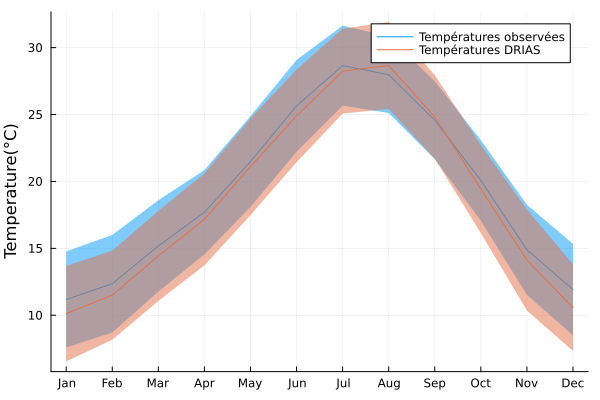

In [108]:
# Charger les données
df = CSV.read("data_station_extract_script/data_tx/MONTPELLIER.txt", DataFrame, skipto = 22, header = 21, comment="#", dateformat = "yyyymmdd", types=Dict(:DATE => Date), normalizenames=true)
df_drias = CSV.read("data_drias/donnees/Montpellier.txt",DataFrame, header = 60, comment="#", dateformat = "yyyymmdd", types=Dict(:Date => Date), normalizenames=true)

# Filtrer les données entre 1970 et 2006
df_filtered = filter(row -> year(row.DATE) >= 1951 && year(row.DATE) <= 2006, df)
df_filtered_drias = filter(row -> year(row.Date) >= 1951 && year(row.Date) <= 2006, df_drias)

# Conversion factor to °C
factor = 0.1

df_month = @chain df_filtered begin
    @subset(:Q_TX .!= 9) # remove missing 
    @transform(:MONTH = month.(:DATE)) # add month column
    @by(:MONTH, :MONTHLY_MEAN = mean(:TX)*factor, :MONTHLY_STD = std(:TX)*factor) # grouby MONTH + takes the mean/std in each category 
end
df_month_drias = @chain df_filtered_drias begin
    @subset(:Tmax .!= 9) # remove missing 
    @transform(:MONTH = month.(:Date)) # add month column
    @by(:MONTH, :MONTHLY_MEAN = mean(:Tmax), :MONTHLY_STD = std(:Tmax)) # grouby MONTH + takes the mean/std in each category 
end


@df df_month plot(monthabbr.(1:12), :MONTHLY_MEAN, ribbon = :MONTHLY_STD, label = "Températures observées")
ylabel!("Temperature(°C)")
@df df_month_drias plot!(monthabbr.(1:12), :MONTHLY_MEAN, ribbon = :MONTHLY_STD, label = "Températures DRIAS")
ylabel!("Temperature(°C)")

AUTOCORRÉLOGRAMME PARTIEL


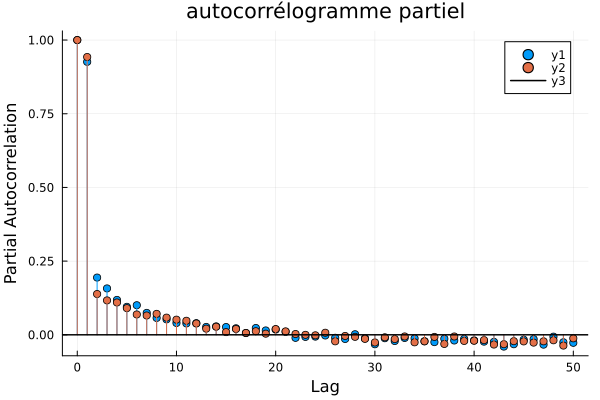

In [109]:
# Calculer la moyenne et l'écart type pour chaque date
df_daily = @chain df_filtered begin
    @subset(:Q_TX .!= 9) # Supprimer les valeurs manquantes 
    @transform(:YEAR = year.(:DATE)) # Ajouter une colonne pour l'année
    @by(:DATE, :DAILY_MEAN = mean(:TX)*factor, :DAILY_STD = std(:TX)*factor) # Grouper par DATE et prendre la moyenne / écart type
end
# Calculer la moyenne et l'écart type pour chaque date
df_daily_drias = @chain df_filtered_drias begin
    @subset(:Tmax .!= 9) # Supprimer les valeurs manquantes 
    @transform(:YEAR = year.(:Date)) # Ajouter une colonne pour l'année
    @by(:Date, :DAILY_MEAN = mean(:Tmax), :DAILY_STD = std(:Tmax)) # Grouper par DATE et prendre la moyenne / écart type
end
# Convertir les données en une série temporelle avec TimeSeries
my_ts = TimeArray(df_daily.DATE, df_daily.DAILY_MEAN)
my_ts_drias = TimeArray(df_daily_drias.Date, df_daily_drias.DAILY_MEAN)

# Extraire les valeurs numériques de la série temporelle
data_values = values(my_ts)
data_values_drias = values(my_ts_drias)

# Calculer l'autocorrélogramme partiel avec un nombre maximal de décalages spécifié
maxlag = 50 # Définir le nombre maximal de décalages
lags = collect(0:maxlag) # Créer une plage de décalages
pacf_values = pacf(data_values, lags)
pacf_values_drias = pacf(data_values_drias, lags)

plot(0:maxlag, pacf_values, xlabel="Lag", ylabel="Partial Autocorrelation", title="autocorrélogramme partiel", markershape=:circle, line=:stem)
plot!(0:maxlag, pacf_values_drias, xlabel="Lag", ylabel="Partial Autocorrelation", title="autocorrélogramme partiel", markershape=:circle, line=:stem)
hline!([0], color=:black, linewidth=1.5)

AUTOCORRÉLOGRAMME EMPIRIQUE

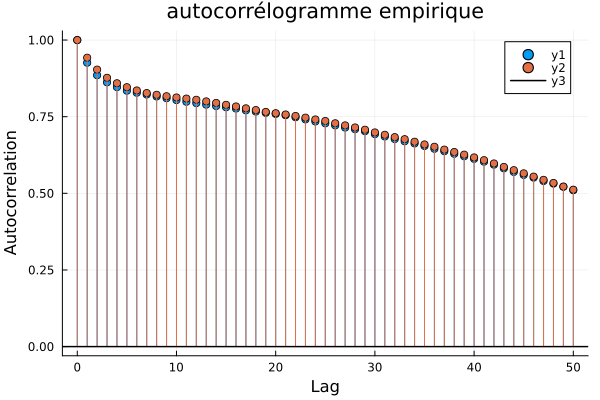

In [110]:
autocor_values = autocor(data_values, lags)
autocor_values_drias = autocor(data_values_drias, lags)

# Tracer l'autocorrélogramme empirique avec les points reliés à l'axe des abscisses et une droite d'équation nulle
plot(0:maxlag, autocor_values, xlabel="Lag", ylabel="Autocorrelation", title="autocorrélogramme empirique", markershape=:circle, line=:stem)
plot!(0:maxlag, autocor_values_drias, xlabel="Lag", ylabel="Autocorrelation", title="autocorrélogramme empirique", markershape=:circle, line=:stem)
hline!([0], color=:black, linewidth=1.5)

SÉRIE TEMPORELLE ET TENDANCE

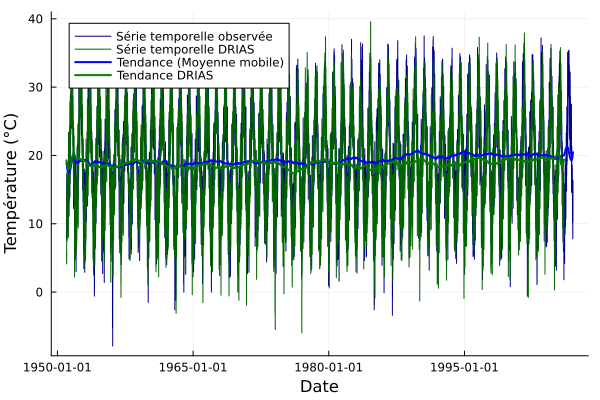

In [125]:
function moyenne_mobile(data::Vector{T}, window_size::Int) where T
    n = length(data)
    trend = similar(data, T)
    for i in 1:n
        start_idx = max(1, i - window_size ÷ 2)
        end_idx = min(n, i + window_size ÷ 2)
        trend[i] = mean(@view(data[start_idx:end_idx]))
    end
    return trend
end

# Calculer la tendance par moyenne mobile avec une fenêtre de taille 730 (deux ans)
trend_values = moyenne_mobile(df_daily.DAILY_MEAN, 730)
trend_values_drias = moyenne_mobile(df_daily_drias.DAILY_MEAN, 730)

# Convertir les données en une série temporelle
datats = TimeArray(df_daily.DATE, df_daily.DAILY_MEAN)
datats_drias = TimeArray(df_daily_drias.Date, df_daily_drias.DAILY_MEAN)

# Tracer la série temporelle avec la tendance
plot(datats, color=:darkblue, label="Série temporelle observée", xlabel="Date", ylabel="Température (°C)", legend=:topleft)
plot!(datats_drias, color=:darkgreen, label="Série temporelle DRIAS", xlabel="Date", ylabel="Température (°C)", legend=:topleft)
plot!(df_daily.DATE, color=:blue, trend_values, label="Tendance (Moyenne mobile)", linewidth=2)
plot!(df_daily_drias.Date,color=:green, trend_values_drias, label="Tendance DRIAS", linewidth=2)


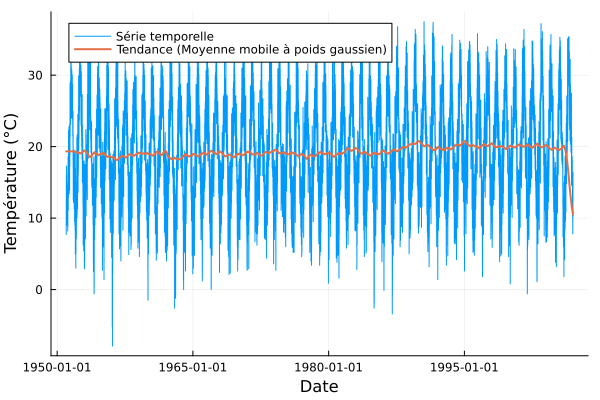

In [105]:

function moyenne_mobile(data::Vector{T}, window_size::Int) where T
    n = length(data)
    trend = similar(data, T)
    for i in 1:n
        weights = exp.(-(collect(1:window_size) .- (window_size ÷ 2)).^2 / (2 * (window_size / 2)^2))
        weights /= sum(weights)  # Normalisation des poids pour que leur somme soit égale à 1
        start_idx = max(1, i - window_size ÷ 2)
        end_idx = min(n, start_idx + window_size - 1)  # Ajustement de la fin de la tranche de données
        data_slice = @view(data[start_idx:end_idx])
        trend[i] = sum(data_slice .* weights[1:length(data_slice)])
    end
    return trend
end

# Calculer la tendance par moyenne mobile avec une fenêtre de taille 730 (deux ans)
trend_values = moyenne_mobile(df_daily.DAILY_MEAN, 730)

# Tracer la série temporelle avec la tendance
plot(datats, label="Série temporelle", xlabel="Date", ylabel="Température (°C)", legend=:topleft)
plot!(df_daily.DATE, trend_values, label="Tendance (Moyenne mobile à poids gaussien)", linewidth=2)

SAISONNALITÉ

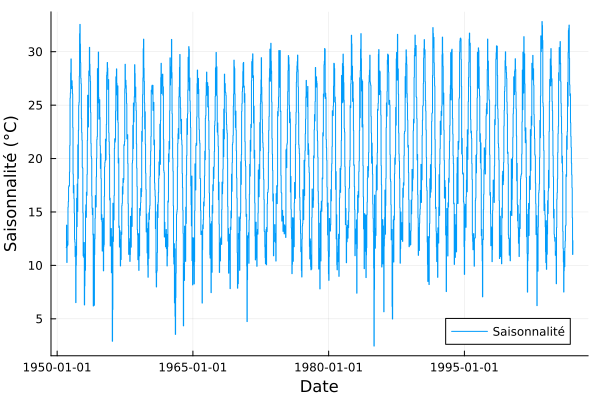

In [106]:

function saisonnalite(data::Vector{T}, period::Int) where T
    n = length(data)
    seasonal = similar(data, T) # Vecteur de la même taille et du meme type que data 
    seasonal_count = Int(ceil(n / period))
    
    seasonal_avg = similar(data, T)
    for i in 1:seasonal_count
        start_idx = (i - 1) * period + 1
        end_idx = min(i * period, n)
        seasonal_avg[start_idx:end_idx] .= mean(@view(data[start_idx:end_idx]))
    end
    
    for i in 1:n
        seasonal[i] = seasonal_avg[i]
    end
    
    return seasonal
end

# Calculer la saisonnalité avec une période saisonnière de 12 mois (par exemple)
seasonal_values = saisonnalite(df_daily.DAILY_MEAN, 12)

# Tracer la série temporelle de la saisonnalité
plot(df_daily.DATE, seasonal_values, label="Saisonnalité", xlabel="Date", ylabel="Saisonnalité (°C)")






BRUIT

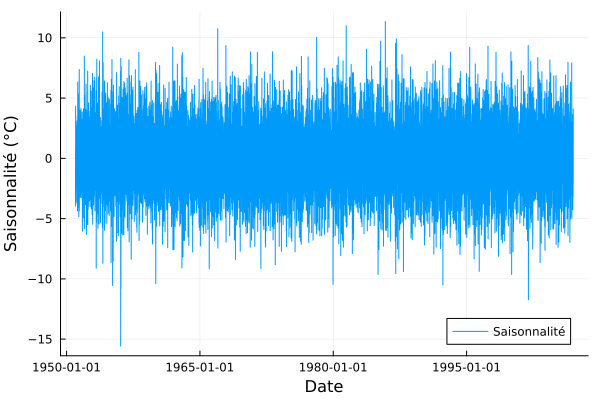

In [107]:

function retiresaisonnalite(data::Vector{T}, period::Int) where T
    n = length(data)
    seasonal = similar(data, T)
    seasonal_count = Int(ceil(n / period))
    
    seasonal_avg = similar(data, T)
    for i in 1:seasonal_count
        start_idx = (i - 1) * period + 1
        end_idx = min(i * period, n)
        seasonal_avg[start_idx:end_idx] .= mean(@view(data[start_idx:end_idx]))
    end
    
    for i in 1:n
        seasonal[i] = data[i] - seasonal_avg[i]
    end
    
    return seasonal
end

# Calculer la saisonnalité avec une période saisonnière de 12 mois (par exemple)
seasonal_values = retiresaisonnalite(df_daily.DAILY_MEAN, 12)


# Tracer la série temporelle de la saisonnalité
plot(df_daily.DATE, seasonal_values, label="Saisonnalité", xlabel="Date", ylabel="Saisonnalité (°C)")